# CS 598 PSL – Project 4: Fashion-MNIST

#### Manas Gandhi (manaspg2), Neeya Devanagondi (neeyati2), Rahul Kasibhatla (rahulk8)

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

RANDOM_STATE = 598
np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid", context="talk")


In [4]:
train_path = "data/fashion-mnist_train.csv"
test_path = "data/fashion-mnist_test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()


Train shape: (60000, 785)
Test shape: (10000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
label_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

#train data
y_train = train_df["label"].values
X_train = train_df.drop(columns=["label"]).values

#test data
y_test = test_df["label"].values
X_test = test_df.drop(columns=["label"]).values

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


X_train: (60000, 784) y_train: (60000,)
X_test: (10000, 784) y_test: (10000,)


## 1a. Frequency Tables of Outcome Variable in both training and testing data

In [7]:
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

train_freq_table = pd.DataFrame({
    "label": train_counts.index,
    "class_name": [label_names[i] for i in train_counts.index],
    "count_train": train_counts.values
})

test_freq_table = pd.DataFrame({
    "label": test_counts.index,
    "class_name": [label_names[i] for i in test_counts.index],
    "count_test": test_counts.values
})

print("Training label frequency:")
display(train_freq_table)

print("\nTesting label frequency:")
display(test_freq_table)

Training label frequency:


,label,class_name,count_train
0,0,T-shirt/top,6000
1,1,Trouser,6000
2,2,Pullover,6000
3,3,Dress,6000
4,4,Coat,6000
5,5,Sandal,6000
6,6,Shirt,6000
7,7,Sneaker,6000
8,8,Bag,6000
9,9,Ankle boot,6000



Testing label frequency:


,label,class_name,count_test
0,0,T-shirt/top,1000
1,1,Trouser,1000
2,2,Pullover,1000
3,3,Dress,1000
4,4,Coat,1000
5,5,Sandal,1000
6,6,Shirt,1000
7,7,Sneaker,1000
8,8,Bag,1000
9,9,Ankle boot,1000


## 1b/2. Data Pre-processing

Each image is already flattened into 784 features in the CSV. We perform:

1. **Scaling** the pixel values using `StandardScaler`.
2. **Dimensionality reduction** using PCA (e.g., 95% variance retained or a fixed number of components).

We will use the PCA-transformed data for:
- 1b.Clustering
- 2.Multi-class classification models


In [ ]:
#scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#PCA: keep enough components to explain ~95% of variance
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Original feature dimension:", X_train.shape[1])
print("Reduced PCA dimension:", X_train_pca.shape[1])


Original feature dimension: 784
Reduced PCA dimension: 256


## 1b. Unsupervised Learning (Q1b)

We apply two clustering algorithms to the training data:

1. K-Means clustering
2. Agglomerative (hierarchical) clustering

We cluster on a random subset of the training data in PCA space to make it less computationally expensive, as we don't have access to GPUs.  
We select the number of clusters using the silhouette score over a range of K.


In [ ]:
#clustering
subset_size = 10000
X_train_pca_subset, _, y_train_subset, _ = train_test_split(
    X_train_pca, y_train,
    train_size=subset_size,
    stratify=y_train,
    random_state=RANDOM_STATE
)

print("Clustering subset shape:", X_train_pca_subset.shape)


Clustering subset shape: (10000, 256)


KMeans: k=5, silhouette score=0.1287
KMeans: k=8, silhouette score=0.1426
KMeans: k=10, silhouette score=0.1369
KMeans: k=12, silhouette score=0.1293
KMeans: k=15, silhouette score=0.1194


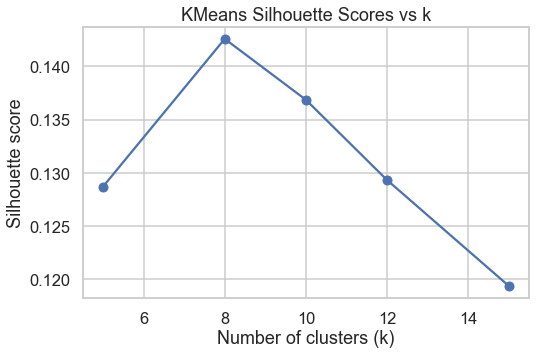

Best k for KMeans based on silhouette score: 8


In [ ]:
k_values = [5, 8, 10, 12, 15]
sil_scores_kmeans = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_pca_subset)
    score = silhouette_score(X_train_pca_subset, cluster_labels)
    sil_scores_kmeans.append(score)
    print(f"KMeans: k={k}, silhouette score={score:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(k_values, sil_scores_kmeans, marker="o")
plt.title("KMeans Silhouette Scores vs k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.show()

best_k_kmeans = k_values[int(np.argmax(sil_scores_kmeans))]
print("Best k for KMeans based on silhouette score:", best_k_kmeans)


In [ ]:
#fit KMeans with best k
kmeans_final = KMeans(n_clusters=best_k_kmeans, random_state=RANDOM_STATE, n_init=10)
clusters_kmeans = kmeans_final.fit_predict(X_train_pca_subset)

cluster_df_kmeans = pd.DataFrame({
    "cluster": clusters_kmeans,
    "true_label": y_train_subset
})

crosstab_kmeans = pd.crosstab(cluster_df_kmeans["cluster"], cluster_df_kmeans["true_label"])
crosstab_kmeans


true_label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,9,0,16,0,2,1,40,0,545,0
1,295,67,336,182,161,270,393,3,226,21
2,637,47,21,267,144,0,214,0,17,6
3,2,0,1,0,0,581,2,817,54,16
4,0,0,0,0,0,112,0,176,32,565
5,41,879,0,538,50,0,9,0,3,1
6,0,0,0,0,0,36,0,4,2,391
7,16,7,626,13,643,0,342,0,121,0


In [ ]:
#dominant labels
dominant_labels_kmeans = crosstab_kmeans.idxmax(axis=1)
dominant_labels_kmeans = dominant_labels_kmeans.rename("dominant_label")

kmeans_summary = pd.concat([crosstab_kmeans, dominant_labels_kmeans], axis=1)
kmeans_summary

,0,1,2,3,4,5,6,7,8,9,dominant_label
cluster,,,,,,,,,,,
0,9,0,16,0,2,1,40,0,545,0,8
1,295,67,336,182,161,270,393,3,226,21,6
2,637,47,21,267,144,0,214,0,17,6,0
3,2,0,1,0,0,581,2,817,54,16,7
4,0,0,0,0,0,112,0,176,32,565,9
5,41,879,0,538,50,0,9,0,3,1,1
6,0,0,0,0,0,36,0,4,2,391,9
7,16,7,626,13,643,0,342,0,121,0,4


Agglomerative: k=5, silhouette score=0.0884
Agglomerative: k=8, silhouette score=0.1149
Agglomerative: k=10, silhouette score=0.1214


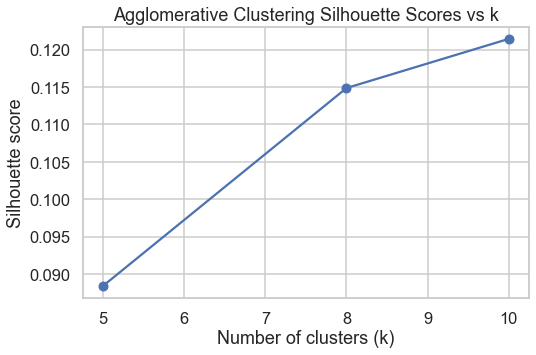

Best k for Agglomerative based on silhouette score: 10


In [13]:
k_values_agg = [5, 8, 10]

sil_scores_agg = []

for k in k_values_agg:
    agg = AgglomerativeClustering(n_clusters=k)
    cluster_labels = agg.fit_predict(X_train_pca_subset)
    score = silhouette_score(X_train_pca_subset, cluster_labels)
    sil_scores_agg.append(score)
    print(f"Agglomerative: k={k}, silhouette score={score:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(k_values_agg, sil_scores_agg, marker="o")
plt.title("Agglomerative Clustering Silhouette Scores vs k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.show()

best_k_agg = k_values_agg[int(np.argmax(sil_scores_agg))]
print("Best k for Agglomerative based on silhouette score:", best_k_agg)


In [14]:
agg_final = AgglomerativeClustering(n_clusters=best_k_agg)
clusters_agg = agg_final.fit_predict(X_train_pca_subset)

cluster_df_agg = pd.DataFrame({
    "cluster": clusters_agg,
    "true_label": y_train_subset
})

crosstab_agg = pd.crosstab(cluster_df_agg["cluster"], cluster_df_agg["true_label"])
crosstab_agg


true_label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,83,963,5,711,122,0,59,0,3,0
1,462,27,259,229,139,9,370,0,22,1
2,9,2,0,4,1,0,30,0,394,0
3,2,1,1,2,5,2,1,0,451,0
4,1,0,0,0,0,528,0,711,2,9
5,37,5,722,50,727,0,437,0,15,0
6,400,0,1,2,2,0,88,0,3,0
7,0,0,0,0,0,20,0,258,6,472
8,0,0,0,0,0,21,0,4,1,420


In [15]:
dominant_labels_agg = crosstab_agg.idxmax(axis=1)
dominant_labels_agg = dominant_labels_agg.rename("dominant_label")

agg_summary = pd.concat([crosstab_agg, dominant_labels_agg], axis=1)
agg_summary


,0,1,2,3,4,5,6,7,8,9,dominant_label
cluster,,,,,,,,,,,
0,83,963,5,711,122,0,59,0,3,0,1
1,462,27,259,229,139,9,370,0,22,1,0
2,9,2,0,4,1,0,30,0,394,0,8
3,2,1,1,2,5,2,1,0,451,0,8
4,1,0,0,0,0,528,0,711,2,9,7
5,37,5,722,50,727,0,437,0,15,0,4
6,400,0,1,2,2,0,88,0,3,0,0
7,0,0,0,0,0,20,0,258,6,472,9
8,0,0,0,0,0,21,0,4,1,420,9


## 2. Multi-class Classification

We consider four multi-class classification methods:

1. Multinomial Logistic Regression
2. Linear Support Vector Machine (SVM)
3. Random Forest
4. k-Nearest Neighbors (k-NN)

All models are trained using the PCA-transformed, scaled features.  
We evaluate performance on the test set using overall classification error, accuracy, and confusion matrices.


In [ ]:
def evaluate_classifier(model, X_train, y_train, X_test, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    test_error = 1 - test_acc
    
    print(f"=== {model_name} ===")
    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Test  accuracy: {test_acc:.4f}")
    print(f"Test  classification error: {test_error:.4f}")
    print("\nClassification report (test):")
    print(classification_report(y_test, y_pred_test, target_names=[label_names[i] for i in range(10)]))
    
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, cmap="Blues",
                xticklabels=[label_names[i] for i in range(10)],
                yticklabels=[label_names[i] for i in range(10)])
    plt.title(f"{model_name} – Confusion Matrix (Test)")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return {
        "model_name": model_name,
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "test_error": test_error
    }


In [ ]:
X_train_pca_full = X_train_pca
y_train_full = y_train

#smaller subset for heavy models
train_size_small = 20000 
X_train_pca_small, _, y_train_small, _ = train_test_split(
    X_train_pca_full, y_train_full,
    train_size=train_size_small,
    stratify=y_train_full,
    random_state=RANDOM_STATE
)

print("Full train PCA shape:", X_train_pca_full.shape)
print("Small train PCA shape:", X_train_pca_small.shape)


Full train PCA shape: (60000, 256)
Small train PCA shape: (20000, 256)


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Multinomial Logistic Regression ===
Train accuracy: 0.8668
Test  accuracy: 0.8572
Test  classification error: 0.1428

Classification report (test):
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.82      0.81      1000
     Trouser       0.96      0.97      0.96      1000
    Pullover       0.78      0.76      0.77      1000
       Dress       0.86      0.88      0.87      1000
        Coat       0.79      0.81      0.80      1000
      Sandal       0.93      0.92      0.92      1000
       Shirt       0.66      0.61      0.63      1000
     Sneaker       0.90      0.92      0.91      1000
         Bag       0.95      0.94      0.94      1000
  Ankle boot       0.93      0.94      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



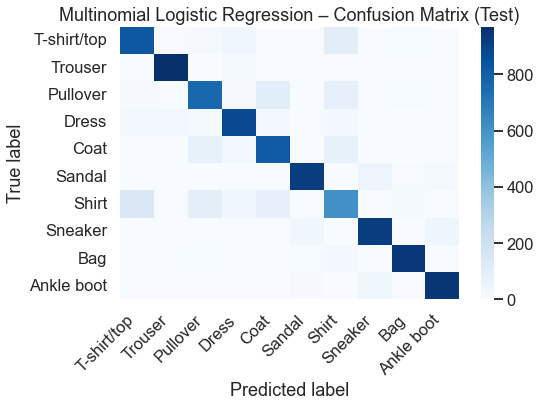

In [19]:
log_reg = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=500,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

results_logreg = evaluate_classifier(
    log_reg,
    X_train_pca_full, y_train_full,
    X_test_pca, y_test,
    model_name="Multinomial Logistic Regression"
)


=== Linear SVM (OvR) ===
Train accuracy: 0.9074
Test  accuracy: 0.8443
Test  classification error: 0.1557

Classification report (test):
              precision    recall  f1-score   support

 T-shirt/top       0.74      0.83      0.78      1000
     Trouser       0.96      0.96      0.96      1000
    Pullover       0.75      0.75      0.75      1000
       Dress       0.85      0.86      0.85      1000
        Coat       0.77      0.79      0.78      1000
      Sandal       0.91      0.92      0.92      1000
       Shirt       0.65      0.59      0.62      1000
     Sneaker       0.90      0.92      0.91      1000
         Bag       0.96      0.89      0.92      1000
  Ankle boot       0.94      0.93      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



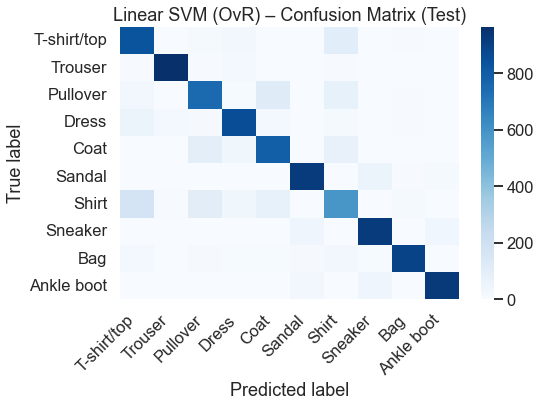

In [ ]:
#we train svm on small subset with linear kernel, too slow if something else
svm_clf = SVC(
    kernel="linear",
    C=1.0,
    decision_function_shape="ovr",
    random_state=RANDOM_STATE
)

results_svm = evaluate_classifier(
    svm_clf,
    X_train_pca_small, y_train_small,
    X_test_pca, y_test,
    model_name="Linear SVM (OvR)"
)


=== Random Forest ===
Train accuracy: 1.0000
Test  accuracy: 0.8670
Test  classification error: 0.1330

Classification report (test):
              precision    recall  f1-score   support

 T-shirt/top       0.79      0.85      0.82      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.80      0.80      0.80      1000
       Dress       0.88      0.91      0.90      1000
        Coat       0.80      0.86      0.83      1000
      Sandal       0.93      0.90      0.91      1000
       Shirt       0.74      0.58      0.65      1000
     Sneaker       0.90      0.89      0.90      1000
         Bag       0.92      0.97      0.95      1000
  Ankle boot       0.89      0.94      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.87      0.87      0.86     10000



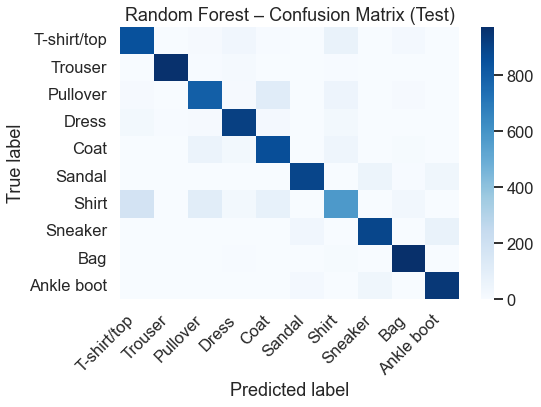

In [21]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

results_rf = evaluate_classifier(
    rf_clf,
    X_train_pca_full, y_train_full,
    X_test_pca, y_test,
    model_name="Random Forest"
)


=== k-Nearest Neighbors (k=5) ===
Train accuracy: 0.8918
Test  accuracy: 0.8493
Test  classification error: 0.1507

Classification report (test):
              precision    recall  f1-score   support

 T-shirt/top       0.74      0.84      0.79      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.77      0.75      0.76      1000
       Dress       0.89      0.88      0.89      1000
        Coat       0.76      0.82      0.79      1000
      Sandal       0.97      0.85      0.91      1000
       Shirt       0.65      0.57      0.61      1000
     Sneaker       0.87      0.93      0.90      1000
         Bag       0.97      0.93      0.95      1000
  Ankle boot       0.89      0.95      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



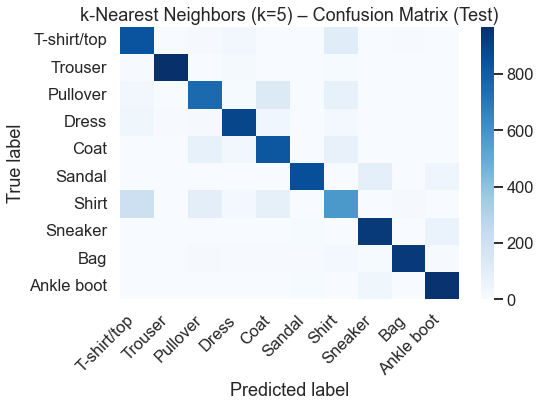

In [ ]:
#small subset here too for speed
knn_clf = KNeighborsClassifier(
    n_neighbors=5,
    weights="uniform",
    metric="minkowski"
)

results_knn = evaluate_classifier(
    knn_clf,
    X_train_pca_small, y_train_small,
    X_test_pca, y_test,
    model_name="k-Nearest Neighbors (k=5)"
)


## Model Comparison

We collect the test set classification errors and accuracies for all four models and present them in a single table.
This table can be used directly in the report.


In [23]:
results_list = [
    results_logreg,
    results_svm,
    results_rf,
    results_knn
]

results_df = pd.DataFrame(results_list)
results_df


,model_name,train_accuracy,test_accuracy,test_error
0,Multinomial Logistic Regression,0.86680,0.8572,0.1428
1,Linear SVM (OvR),0.90745,0.8443,0.1557
2,Random Forest,1.00000,0.8670,0.1330
3,k-Nearest Neighbors (k=5),0.89175,0.8493,0.1507
